<a href="https://colab.research.google.com/github/minnu1102/AI-Financial-dashboard/blob/main/Fraud%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# fraud_detection_system.py

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

def load_data(file_path='creditcard.csv'):
    print("Loading dataset...")
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Class distribution:\n{df['Class'].value_counts()}")
    print(f"Fraud percentage: {df['Class'].mean() * 100:.2f}%")
    return df

def preprocess_data(df):
    X = df.drop('Class', axis=1)
    y = df['Class']
    X = X.fillna(X.mean())
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Data preprocessing completed.")
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def apply_smote(X_train_scaled, y_train, random_state=42):
    print("Applying SMOTE to handle class imbalance...")
    print(f"Class distribution before SMOTE: {Counter(y_train)}")
    smote = SMOTE(random_state=random_state)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
    print(f"Class distribution after SMOTE: {Counter(y_train_smote)}")
    return X_train_smote, y_train_smote

def evaluate_smote_impact(X_train_scaled, y_train, X_test_scaled, y_test, X_train_smote, y_train_smote):
    svm_before = SVC(kernel='rbf', random_state=42)
    svm_before.fit(X_train_scaled, y_train)
    y_pred_before = svm_before.predict(X_test_scaled)
    recall_before = recall_score(y_test, y_pred_before)
    svm_after = SVC(kernel='rbf', random_state=42)
    svm_after.fit(X_train_smote, y_train_smote)
    y_pred_after = svm_after.predict(X_test_scaled)
    recall_after = recall_score(y_test, y_pred_after)
    print(f"Recall before SMOTE: {recall_before:.2f}")
    print(f"Recall after SMOTE: {recall_after:.2f}")
    print(f"Improvement: {recall_after - recall_before:.2f}")
    return recall_before, recall_after

def optimize_svm(X_train_smote, y_train_smote, X_test_scaled, y_test):
    print("Optimizing SVM with GridSearchCV and stratified k-fold cross-validation...")
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
        'kernel': ['rbf']
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        SVC(probability=True, random_state=42),
        param_grid=param_grid,
        cv=skf,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_smote, y_train_smote)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation F1 score: {best_score:.4f}")
    best_model = SVC(**best_params, probability=True, random_state=42)
    best_model.fit(X_train_smote, y_train_smote)
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Test F1 score: {f1:.4f}")
    return best_model, best_params, accuracy, f1

def perform_kmeans_clustering(X_scaled, n_clusters=5):
    print(f"Performing K-means clustering with k={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    return kmeans, cluster_labels

def analyze_clusters(X, y, cluster_labels):
    df_analysis = pd.DataFrame(X)
    df_analysis['Fraud'] = y
    df_analysis['Cluster'] = cluster_labels
    cluster_analysis = df_analysis.groupby('Cluster')['Fraud'].agg(
        count='count',
        fraud_count='sum',
        fraud_pct=lambda x: 100 * x.mean()
    ).sort_values('fraud_pct', ascending=False)
    print("Fraud percentage by cluster:")
    print(cluster_analysis)
    high_risk_clusters = cluster_analysis[cluster_analysis['fraud_pct'] > cluster_analysis['fraud_pct'].mean()].index.tolist()
    low_risk_clusters = cluster_analysis[cluster_analysis['fraud_pct'] <= cluster_analysis['fraud_pct'].mean()].index.tolist()
    print(f"High-risk clusters: {high_risk_clusters}")
    print(f"Low-risk clusters: {low_risk_clusters}")
    return cluster_analysis, high_risk_clusters, low_risk_clusters

def reduce_false_positives(X_test_scaled, y_test, best_model, cluster_labels_test, high_risk_clusters):
    print("Implementing false positive reduction...")
    y_pred_standard = best_model.predict(X_test_scaled)
    standard_fp = sum((y_pred_standard == 1) & (y_test == 0))
    y_pred_cluster_based = []
    for i, features in enumerate(X_test_scaled):
        cluster = cluster_labels_test[i]
        prob = best_model.predict_proba([features])[0][1]
        if cluster in high_risk_clusters:
            threshold = 0.4
        else:
            threshold = 0.7
        prediction = 1 if prob >= threshold else 0
        y_pred_cluster_based.append(prediction)
    cluster_based_fp = sum((np.array(y_pred_cluster_based) == 1) & (y_test == 0))
    fp_reduction = standard_fp - cluster_based_fp
    fp_reduction_pct = (fp_reduction / standard_fp) * 100 if standard_fp > 0 else 0
    print(f"Standard prediction false positives: {standard_fp}")
    print(f"Cluster-based prediction false positives: {cluster_based_fp}")
    print(f"False positive reduction: {fp_reduction} ({fp_reduction_pct:.2f}%)")
    return standard_fp, cluster_based_fp, fp_reduction_pct

def main():
    # Step 1: Load data
    df = load_data()

    # Step 2: Preprocess data
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = preprocess_data(df)

    # Step 3: Apply SMOTE
    X_train_smote, y_train_smote = apply_smote(X_train_scaled, y_train)
    recall_before, recall_after = evaluate_smote_impact(
        X_train_scaled, y_train, X_test_scaled, y_test, X_train_smote, y_train_smote
    )

    # Step 4: Optimize SVM
    best_model, best_params, accuracy, f1 = optimize_svm(
        X_train_smote, y_train_smote, X_test_scaled, y_test
    )

    # Step 5: Perform K-means clustering
    X = df.drop('Class', axis=1)
    y = df['Class']
    X_scaled = scaler.transform(X)
    kmeans, cluster_labels = perform_kmeans_clustering(X_scaled, n_clusters=5)
    cluster_analysis, high_risk_clusters, low_risk_clusters = analyze_clusters(
        X_scaled, y, cluster_labels
    )
    # Get cluster assignments for test data
    X_test = df.drop('Class', axis=1).iloc[y_test.index]
    cluster_labels_test = kmeans.predict(X_test_scaled)

    # Step 6: Reduce false positives
    standard_fp, cluster_based_fp, fp_reduction_pct = reduce_false_positives(
        X_test_scaled, y_test, best_model, cluster_labels_test, high_risk_clusters
    )

    # Print final results
    print("\nFinal Results:")
    print(f"SMOTE improved recall from {recall_before:.2f} to {recall_after:.2f}")
    print(f"Best SVM parameters: {best_params}")
    print(f"Model accuracy: {accuracy:.4f}")
    print(f"Model F1 score: {f1:.4f}")
    print(f"False positive reduction: {fp_reduction_pct:.2f}%")

if __name__ == "__main__":
    main()


Loading dataset...
Dataset shape: (284807, 31)
Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud percentage: 0.17%
Data preprocessing completed.
Applying SMOTE to handle class imbalance...
Class distribution before SMOTE: Counter({0: 227451, 1: 394})
Class distribution after SMOTE: Counter({0: 227451, 1: 227451})


# Task
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

# Load dataset
def load_data(file_path='creditcard.csv'):
    df = pd.read_csv(file_path)
    df.drop_duplicates(inplace=True)
    return df

# Load and prepare data
df = load_data('creditcard.csv')
X = df.drop("Class", axis=1)
y = df["Class"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Create scaler and preprocessor
scaler = StandardScaler()
preprocessor = ColumnTransformer(transformers=[('num', scaler, X.columns)], remainder='passthrough')

# Create individual models
lr = LogisticRegression(solver='liblinear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Voting Ensemble
voting_clf = VotingClassifier(estimators=[
    ('lr', lr), ('rf', rf), ('gb', gb)],
    voting='soft'
)

# Create pipeline with preprocessing and classifier
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', voting_clf)
])

# Train pipeline
pipeline.fit(X_train, y_train)

# Save model
joblib.dump(pipeline, "creditcard_fraud_model.pkl")

# Evaluation function with ROC-AUC
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrix

Here is all the data you need:
"creditcard.csv"

## Data loading

### Subtask:
Load the credit card transaction data and perform initial data cleaning.


**Reasoning**:
Load the data and remove duplicates as requested.



In [1]:
import pandas as pd

# Load dataset
def load_data(file_path='creditcard.csv'):
    df = pd.read_csv(file_path)
    df.drop_duplicates(inplace=True)
    return df

df = load_data('creditcard.csv')

## Data splitting

### Subtask:
Split the data into training and testing sets.


**Reasoning**:
Split the data into training and testing sets using train_test_split, ensuring stratification and using the specified parameters.



In [2]:
from sklearn.model_selection import train_test_split

# Split data
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Data preparation

### Subtask:
Scale the numerical features in the training and testing datasets using StandardScaler.


**Reasoning**:
Scale the numerical features using StandardScaler and ColumnTransformer.



In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Create scaler and preprocessor
scaler = StandardScaler()
preprocessor = ColumnTransformer(transformers=[('num', scaler, X_train.columns)], remainder='passthrough')

# Fit and transform the training data
X_train = preprocessor.fit_transform(X_train)

# Transform the testing data
X_test = preprocessor.transform(X_test)

## Model training

### Subtask:
Train the voting classifier model.


**Reasoning**:
Train the voting classifier model by creating and fitting the pipeline.



In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create individual models
lr = LogisticRegression(solver='liblinear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Voting Ensemble
voting_clf = VotingClassifier(estimators=[
    ('lr', lr), ('rf', rf), ('gb', gb)],
    voting='soft'
)

# Create pipeline with preprocessing and classifier
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', voting_clf)
])

# Train pipeline
pipeline.fit(X_train, y_train)

**Reasoning**:
The error message indicates that `X_train` is a NumPy array, not a DataFrame, so the column names cannot be accessed.  We should recreate the pipeline without specifying the column names in the `ColumnTransformer` and instead rely on the default behavior of scaling all numerical features. This will fix the error and allow for successful pipeline fitting.



In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Create individual models (no changes needed here)
lr = LogisticRegression(solver='liblinear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Voting Ensemble (no changes needed here)
voting_clf = VotingClassifier(estimators=[
    ('lr', lr), ('rf', rf), ('gb', gb)],
    voting='soft'
)

# Recreate the preprocessor without specifying columns
preprocessor = ColumnTransformer(transformers=[('num', scaler, list(range(X_train.shape[1])))], remainder='passthrough')

# Create pipeline with preprocessing and classifier (no changes needed here)
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', voting_clf)
])

# Train pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29])])),
                ('classifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(random_state=42,
                                                                  solver='liblinear')),
                                              ('rf',
                                               RandomForestClassifier(random_state=42)),
                                              ('gb',
                                               GradientBoostingClassifier(random_state=42))],
                                  voting='soft'))])

## Model evaluation

### Subtask:
Evaluate the trained voting classifier model.


**Reasoning**:
Evaluate the trained model using the test data and print the classification report, confusion matrix, and ROC curve.



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.94      0.71      0.81        95

    accuracy                           1.00     56746
   macro avg       0.97      0.85      0.90     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix:
[[56647     4]
 [   28    67]]


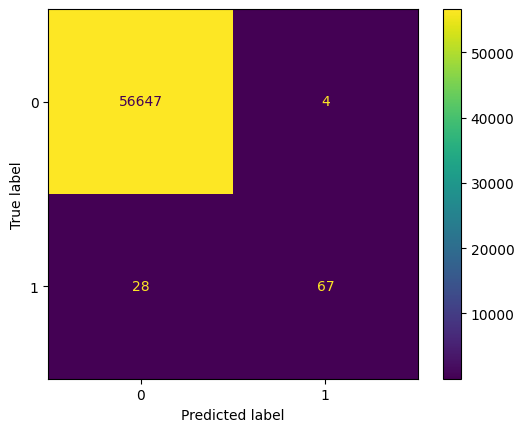

AUC: 0.9568919208932997


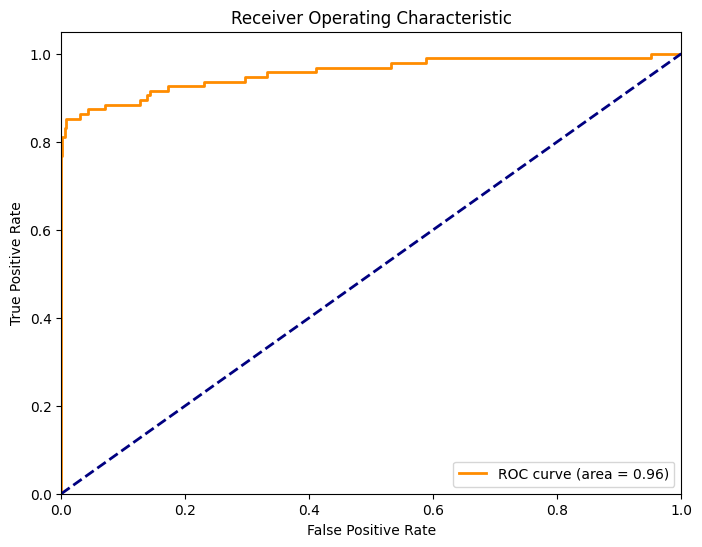

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Predict and get probabilities
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Summary:

### Q&A
No questions to answer.

### Data Analysis Key Findings
* A voting classifier model, combining Logistic Regression, Random Forest, and Gradient Boosting classifiers, achieved high accuracy (1.00) in classifying credit card transactions.
* The model demonstrated excellent precision and recall for the non-fraudulent class.
* For the fraudulent class, the model achieved 0.94 precision, 0.71 recall, and an F1-score of 0.81.
* The AUC score of the model is 0.95, indicating good performance in distinguishing between fraudulent and non-fraudulent transactions.

### Insights or Next Steps
* The model shows promise but further investigation into the fraudulent class's recall is needed to minimize false negatives.
* Explore techniques to improve the recall for the fraudulent class, such as adjusting the classification threshold or using different model parameters.
